In [445]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max
from sklearn.cluster import KMeans
from imtools import get_imlist

In [446]:
def show(img, title='my picture'):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

In [447]:
def make_mask(value, img):
    copy_img = img
    mask = copy_img < value
    copy_img[mask] = 0
    return copy_img

In [448]:
def centre(coord, dist):
    centre = []
    for index in range(len(coord[:-1])):
        if np.sum((coord[index] - coord[index + 1])**2)**0.5 < dist:
            centre.append(np.abs(coord[index] + coord[index + 1])//2)
        else:
            centre.append(coord[index])
    return np.asarray(centre)

In [449]:
def filtering_max(coordinates, maximum, scale, value=0.05):
    filtered = maximum[coordinates[:, 0], coordinates[:, 1]] > value
    coordinates = coordinates[filtered]
    return coordinates

In [450]:
def mean_pooling(img, scale):
    h_, w_ = 0, 0
    save_mean = []
    for h in range(10, 110, scale):
        h_ = h_ + 1
        for w in range(10, 189, scale):
            save_mean.append(img[h - 10: h, w - 10: w].mean())
    w_ = len(save_mean) // h_
    save_mean = np.asarray(save_mean).reshape(h_, w_)
    return save_mean

In [451]:
def count_cluster(first, dots, radius):
    lst = []
    first = np.ones(dots.shape)*first
    dist = np.ones(dots.shape[0])
    arr = (first - dots)**2
    
    for index, el in enumerate(arr):
        dist[index] = np.sqrt(np.sum(el))
    index = (dist > radius)
    for j, i in enumerate(index):
        if i:
            lst.append(dots[j])
    if len(lst) > 0:
        return count_cluster(lst[0], np.asarray(lst[1:]), radius) + 1
    else:
        return 1

In [452]:
def find_cluster(n_clusters, coordinates, mode='default', init='k-means++'):
    """
    finds clusters and return a dictionary with keys 'clusters', 'coordinates'
    where 'coordinates' are coordinates of local peek maxima
    
    n_clusters - float
    coordinates - numpy.ndarray
    mode - str - is optional, if the mode is +- do clustering for number of clusters  
    [n_clusters - 1, n_clusters, n_clusters + 1] 
    in that case dots['clusters_centres'].shape = (3,)
    init - str - init for Kmeans
    """
    dots = {}
    if mode == 'default':
        kmeans_centers = [KMeans(n_clusters=n_clusters, random_state=0, init='k-means++').fit(coordinates)]
    if mode == '+-':
        kmeans_centers = [KMeans(n_clusters=i, random_state=0, init='k-means++').fit(coordinates) for i in range(n_clusters - 1, n_clusters + 2)]
        
    dots['clusters'] = np.asarray(kmeans_centers)
    dots['coordinates'] = coordinates
    return dots

In [453]:
def make_square_box(dots, box_shape, shape, center=False):
    y, x = shape
    shift = box_shape//4
    boxes = []
    for dot in dots['coordinates']:
    #left_up
        dot_boxes = []
        check = box(shift, dot, 'l_up')
        right_down_y = crop_number(check[0], (-99999, y))
        right_down_x = crop_number(check[1], (-99999, x))
        left_up_y = crop_number(check[2], (0, 99999))
        left_up_x = crop_number(check[3], (0, 99999))
        dot_boxes.append([left_up_y, left_up_x, right_down_y, right_down_x])

        check = box(shift, dot, 'r_up')
        left_down_y = crop_number(check[0], (-99999, y))
        left_down_x = crop_number(check[1], (0, 99999))
        right_up_y = crop_number(check[2], (0, 99999))
        right_up_x = crop_number(check[3], (-99999, x))
        dot_boxes.append([right_up_y, left_down_x, left_down_y, right_up_x])

        check = box(shift, dot, 'l_d')
        right_up_y = crop_number(check[0], (0, 99999))
        right_up_x = crop_number(check[1], (-99999, x))
        left_down_y = crop_number(check[2], (-99999, y))
        left_down_x = crop_number(check[3], (0, 99999))
        dot_boxes.append([left_up_y, left_up_x, right_down_y, right_down_x])

        check = box(shift, dot, 'r_d')
        right_up_y = crop_number(check[0], (0, 99999))
        rigt_up_x = crop_number(check[1], (0, 99999))
        left_down_y = crop_number(check[2], (-99999, y))
        left_down_x = crop_number(check[3], (-99999, x))
        dot_boxes.append([right_up_y, left_down_x, left_down_y, rigt_up_x])

        if center:
            check = box(box_shape//2, dot, 'center')
            right_up_y = crop_number(check[0], (0, 99999))
            rigt_up_x = crop_number(check[1], (0, 99999))
            left_down_y = crop_number(check[2], (-99999, y))
            left_down_x = crop_number(check[3], (-99999, x))
            dot_boxes.append([right_up_y, left_down_x, left_down_y, rigt_up_x])
        boxes.append(dot_boxes)

            
    for cluster in dots['clusters']:
        clusters_dots = cluster.cluster_centers_
        for cluster_dot in clusters_dots:
            cluster_dot = int(cluster_dot[0]), int(cluster_dot[1])
            check = box(box_shape//2, cluster_dot, 'center')
            right_up_y = crop_number(check[0], (0, 99999))
            rigt_up_x = crop_number(check[1], (0, 99999))
            left_down_y = crop_number(check[2], (-99999, y))
            left_down_x = crop_number(check[3], (-99999, x))
            boxes.append([[right_up_y, left_down_x, left_down_y, rigt_up_x]])

    return np.asarray(boxes)

In [454]:
def crop_number(numb, limits):
    if numb < limits[0]:
        return limits[0]
    if numb > limits[1]:
        return limits[1]
    return int(numb)

In [455]:
def box(shift, dot, where):
    box_coord = []
    #r -> smaller_diag_y, smaller_diag_x, bigger_diag_y, bigger_diag_x
    #where - where the shifts go l_up, r_up, l_d, r_d, center
    if where == 'r_d':
        return (dot[0] - shift, dot[1] - shift, dot[0] + 3*shift, dot[1] + 3*shift)
    if where == 'l_up':
        return (dot[0] + shift, dot[1] + shift, dot[0] - 3*shift, dot[1] - 3*shift)
    if where == 'l_d':
        return (dot[0] - shift, dot[1] + shift, dot[0] + 3*shift, dot[1] - 3*shift)
    if where == 'r_up':
        return (dot[0] + shift, dot[1] - shift, dot[0] - 3*shift, dot[1] + 3*shift)
    if where == 'center':
        return (int(dot[0] - shift), int(dot[1] - shift), int(dot[0] + shift), int(dot[1] + shift))

In [456]:
def crop(box, img):
    #condition_is_true if condition else condition_is_false
    y = []
    x = []
    y.append((box[0], box[2])) if box[0] < box[2] else y.append((box[2], box[0])) #y_slicing
    x.append((box[1], box[3])) if box[1] < box[3] else x.append((box[3],box[1])) #x_slicing

    return img[y[0][0]:y[0][1], x[0][0]:x[0][1]]

In [457]:
def generating_boxes(dots, img, box_shape, shape, optimization=False):
    croped_image = []
    #score = [] #for evalueting

    boxes = make_square_box(dots, box_shape, shape)  #making our boxes for each dot, 
                                                     #each dot has array which includes the box coordinates  which was generated aroud this dot
    for index, dot_boxes in enumerate(boxes):        # dot_boxes - boxes generated around one dot
        dot_boxes_scores = []
        for box in dot_boxes:                        #evalueting all boxes generated from one dot and save this scores in dot_boxes_scores
            if optimization and index < dots['coordinates'].shape[0]: #(evaluate only box generated from max peek)
                dot_boxes_scores.append(evalueting_cropping(box, dots, img, dots['clusters'][0].labels_[index]))
        if optimization and len(dot_boxes_scores) > 0:
            first, second = index_two_min(dot_boxes_scores) # taking index of the boxes with the lowest scores
            values = dot_boxes[first], dot_boxes[second]    # taking these boxes
            
            for value in values:
                dot_boxes.remove(value)                     # removing bad boxes
            
        good = [crop(box, img) for box in dot_boxes]    # cropping good boxes
        croped_image.append(good)
            #score.append(dot_boxes_scores)          #saving in score, in this case, the one element from the score array it is an array 
                                                     #with scores from each box generated from one dot
    return np.asarray(croped_image)

In [458]:
def evalueting_cropping(box, dots, img, cluster):
    coords, clustered = dots['coordinates'], dots['clusters']
    number_self_dots = 0.000000001
    number_alien_dots = 0.000000001
    finded_clusters = []
    count_clusters = 1
    
    summa = np.sum(crop(box, img))
    for index, coord in enumerate(coords):
        if in_box(coord, box):
            cluster_ = clustered[0].labels_[index]
            if cluster != cluster_:
                number_alien_dots = number_alien_dots + 1
                if cluster_ not in finded_clusters:
                    finded_clusters.append(cluster_)
                    count_clusters = count_clusters + 1
            else:
                number_self_dots = number_self_dots + 1
    value = summa * number_self_dots / (number_alien_dots * count_clusters)
    return round(value, 3)

In [459]:
def in_box(coord, box):
    if box[0] < box[2]:
        y = box[0], box[2]
    else:
        y = box[2], box[0]
    if box[1] < box[3]:
        x = box[1], box[3]
    else:
        x = box[3], box[1]
    if  y[0] <= coord[0] and coord[0] <= y[1]:
        if x[0] <= coord[1]  and coord[1] <= x[1]:
            return True
    return False
    
    #check is the dot in box or not

In [460]:
def index_two_min(arr):
    if arr[0] < arr[1]:
        index_of_min, index_of_second = 0, 1
    else:
        index_of_min, index_of_second = 1, 0
    for index, element in enumerate(arr[2:]):
        if element < arr[index_of_min]:
            index_of_second = index_of_min
            index_of_min = index + 2
        elif element < arr[index_of_second]:
            index_of_second = index + 2
    return index_of_min, index_of_second

In [461]:
SCALE = 2 #for pooling
MIN_DISTANCE = 2 #radius for finding local max
MASK_VALUE = 0.3

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(1, 933 + 1) instead
  after removing the cwd from sys.path.


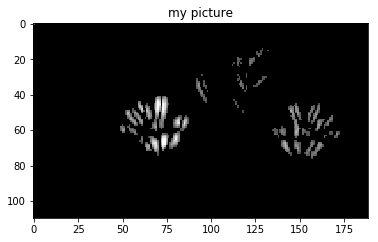

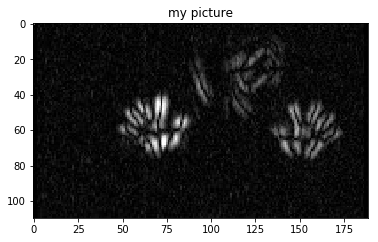

In [462]:
images_path = get_imlist('Test189x110/27734/')
count = len(images_path) - 1

index = np.random.random_integers(count)
original_img = cv2.imread(images_path[index])[:,:,0]

img = original_img/255
#show(img)

im = make_mask(MASK_VALUE, img)
show(im)
show(original_img)

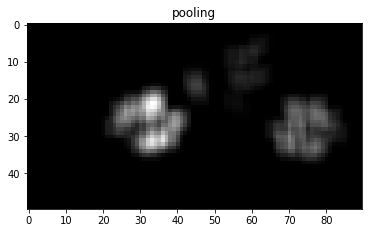

(50, 90)

In [463]:
maximum = mean_pooling(img, SCALE)
show(maximum, title='pooling')
maximum.shape

anticipated number of clusters  4


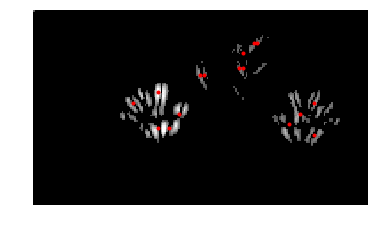

In [464]:
coordinates = filtering_max(peak_local_max(maximum, min_distance=MIN_DISTANCE), maximum, SCALE)
max_coord = (coordinates + MIN_DISTANCE) * SCALE
n_clusters = count_cluster(max_coord[0], max_coord[1:], 30)
clusters = find_cluster(n_clusters, max_coord, mode='default', init='k-means++')
print("anticipated number of clusters ", n_clusters)

plt.imshow(im, cmap=plt.cm.gray)
plt.plot(max_coord[:, 1], max_coord[:, 0], 'r.')
plt.axis('off')
plt.show()

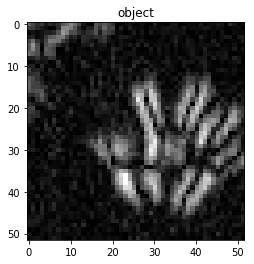

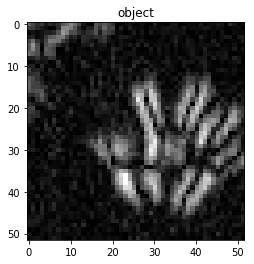

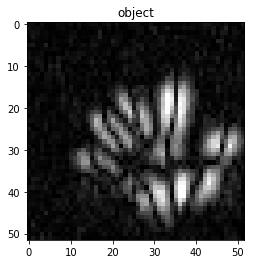

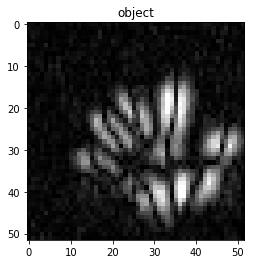

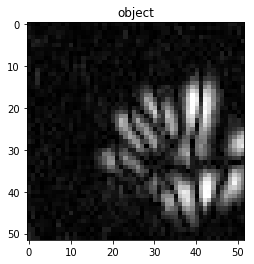

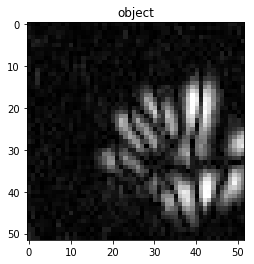

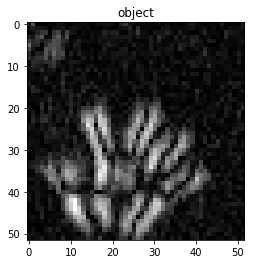

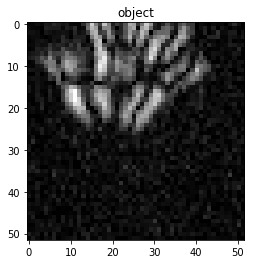

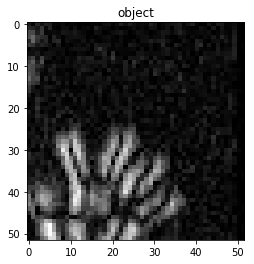

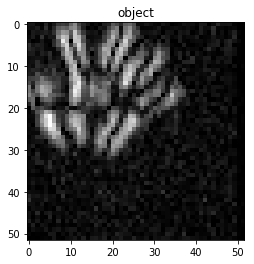

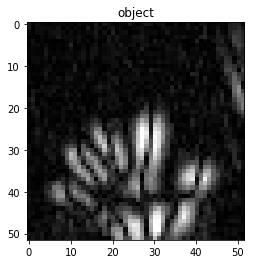

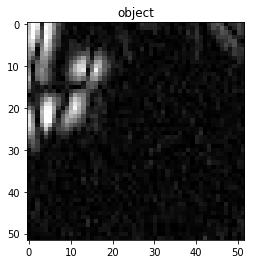

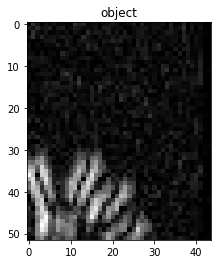

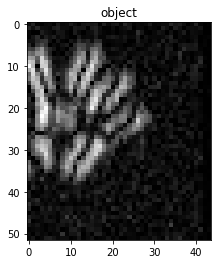

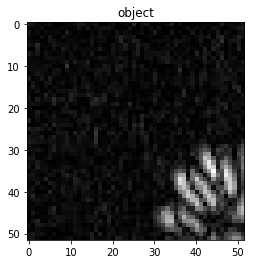

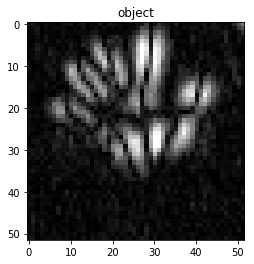

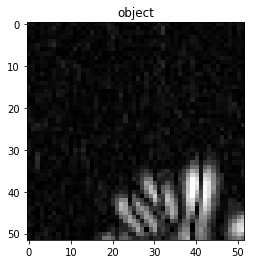

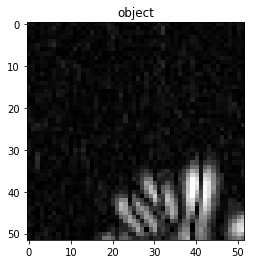

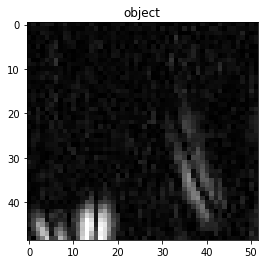

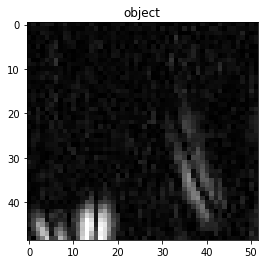

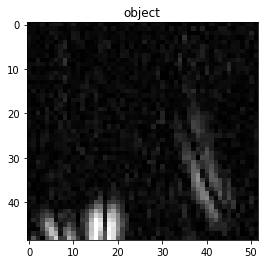

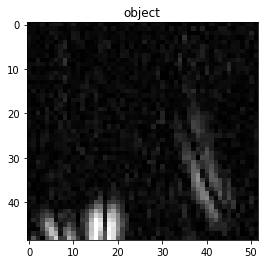

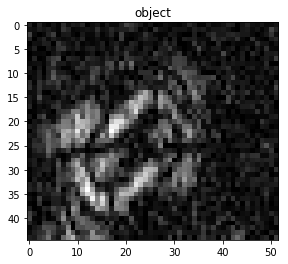

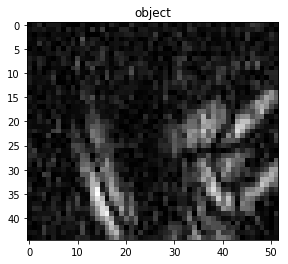

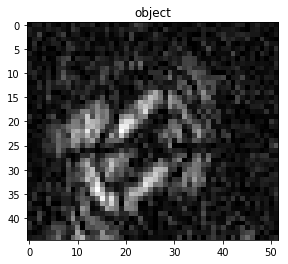

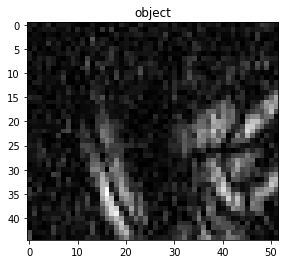

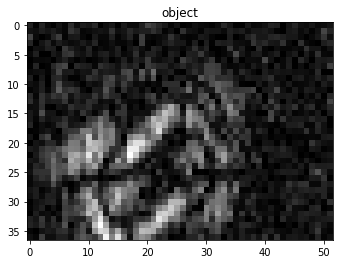

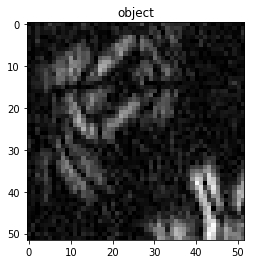

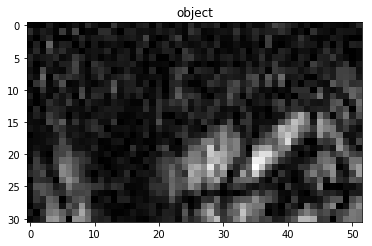

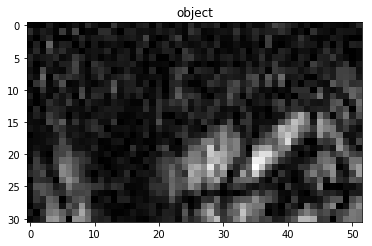

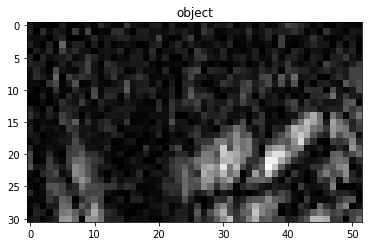

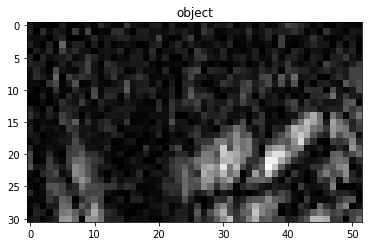

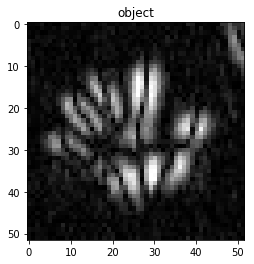

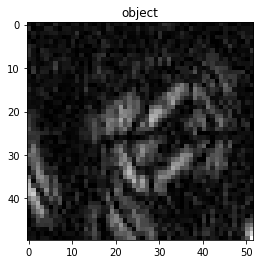

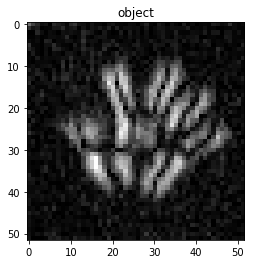

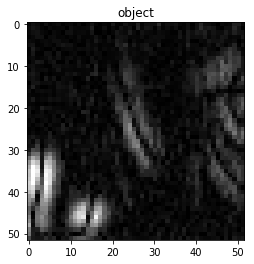

In [465]:
generated = generating_boxes(clusters, original_img, 53, (110, 189), optimization=True)

plt.imshow(original_img, cmap=plt.cm.gray)
plt.plot(clusters['coordinates'][:, 1], clusters['coordinates'][:, 0], 'r.')
plt.plot(clusters['clusters'][0].cluster_centers_[:, 1], clusters['clusters'][0].cluster_centers_[:, 0], 'b.')


for g in generated:
    for gi in g:
        show(gi, title='object')